# Point Cloud-to-Simplicial Feature-Based Vietoris Rips Complex Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

There is a set of available datasets that you can play with from the gudhi python library.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* gudhi_sphere
* gudhi_torus
* gudhi_bunny
* gudhi_spiral_2d
* gudhi_daily_activities

Please see the gudhi documentation [1] for a description of these datasets and the relevant config options. Note that *all datasets except gudhi_daily_activities lack features and targets*. You must instead provide a feature_generator and target_generator in the PointCloudLoader

[[1]](https://gudhi.inria.fr/python/latest/index.html) GUDHI Python documentation
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import PointCloudLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "manual_points"
dataset_config = load_dataset_config(dataset_name)

# Note that some point cloud datasets may not have features or targets
# In this case you must provide the feature_generator and target_generator methods yourself!
loader = PointCloudLoader(dataset_config)


Dataset configuration for manual_points:

{'data_domain': 'pointcloud',
 'data_type': 'toy_dataset',
 'data_name': 'manual_points',
 'data_dir': 'datasets/pointcloud/toy_dataset',
 'dim': 2,
 'num_classes': 2,
 'num_samples': 7,
 'num_features': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


Processing...
Done!


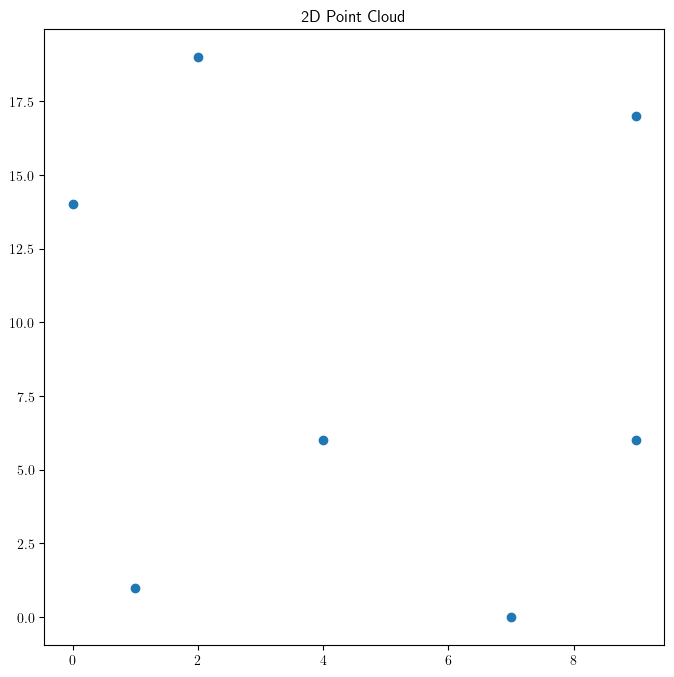

 - Set with 7 points.
 - Features dimension: 2



In [3]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. For this example the Vietoris-Rips (or Rips) complex lifting was chosen. It is generated in two steps - first pairwise distances between points are computed, and for any pair with distance $\le d$, an edge is added. The simplicial complex is then the clique complex of this graph. 

Note that this implementation *includes features* in the pairwise distance. More precisely, the parameter `feature_percent` allows the user to adjust how much weight to give to feature differences in the overall distance. Currently the feature distance is simply the Euclidean distance between feature vectors, which is combined with the usual Euclidean distance to generate the final pairwise distances.

This can be useful in cases where the features correspond to a *signal* on a surface. For example, temperature measurments on the surface of a human body. If your arms are by your side, a naïve point cloud complex might interpret the points in your hand as being very close to those of your torso. However, your hand is in fact quite far since the 'true' distance goes up your arm. The feature-based lifting may be able to distinguish this since the feature values are likely quite different, hence the points will not be connected in the lifting.

The GUDHI library is used to compute the complex [1].

---
[[1]](https://gudhi.inria.fr/python/latest/rips_complex_user.htm) Gudhi Rips Complex User Manual

---

For simplicial complexes creating a lifting involves creating a `SimplicialComplex` object from topomodelx and adding simplices to it using the method `add_simplices_from`. The `SimplicialComplex` class then takes care of creating all the needed matrices.

Similarly to before, we can specify the transformation we want to apply through its type and id --the correxponding config files located at `/configs/transforms`. 

Note that the *tranform_config* dictionary generated below can contain a sequence of tranforms if it is needed.

This can also be used to explore liftings from one topological domain to another, for example using two liftings it is possible to achieve a sequence such as: graph -> simplicial complex -> hypergraph. 

In [4]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "pointcloud2simplicial/feature_rips_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for pointcloud2simplicial/feature_rips_lifting:

{'transform_type': 'lifting',
 'transform_name': 'FeatureRipsComplexLifting',
 'complex_dim': 3,
 'feature_percent': 0.2,
 'max_edge_length': 10.0,
 'sparse': None,
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcesor`:


Dataset only contains 1 sample:


Processing...
/Users/tlong/anaconda3/envs/topox/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
Done!


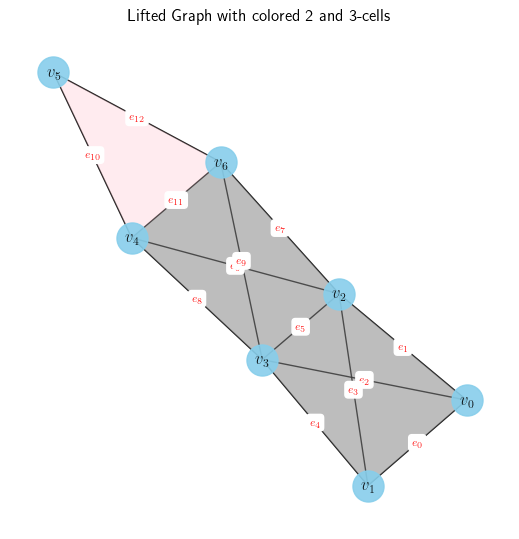

 - The complex has 7 0-cells.
 - The 0-cells have features dimension 2
 - The complex has 13 1-cells.
 - The 1-cells have features dimension 2
 - The complex has 9 2-cells.
 - The 2-cells have features dimension 2
 - The complex has 2 3-cells.
 - The 3-cells have features dimension 2



In [5]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

## Illustrating how the Feature-based Rips Complex differs from the standard Rips complex

Let's see what the effect of the `feature_percent` parameter is. The Rips complex is generated based on **pairwise distances** between points. Usually these are calculated using the usual Euclidean distance of point positions, however this implementation also lets us linearly combine this with the distance between **feature vectors**.

In [6]:
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for pointcloud2simplicial/feature_rips_lifting:

{'transform_type': 'lifting',
 'transform_name': 'FeatureRipsComplexLifting',
 'complex_dim': 3,
 'feature_percent': 0.2,
 'max_edge_length': 10.0,
 'sparse': None,
 'feature_lifting': 'ProjectionSum'}


With `feature_percent=0.0`, we obtain the 'standard' Rips Complex, which is based only on the distances between points.


Dataset only contains 1 sample:


Processing...
Done!


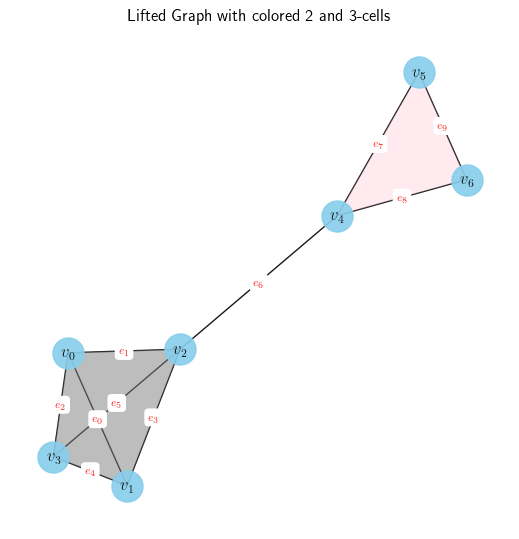

 - The complex has 7 0-cells.
 - The 0-cells have features dimension 2
 - The complex has 10 1-cells.
 - The 1-cells have features dimension 2
 - The complex has 5 2-cells.
 - The 2-cells have features dimension 2
 - The complex has 1 3-cells.
 - The 3-cells have features dimension 2



In [7]:
transform_config["lifting"]["feature_percent"] = 0.0
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

With `feature_percent=1.0`, the distances between points are **entirely** based on the features. There are only 3 unique feature vectors in this dataset - 3 vertices with feature vector `[0.0, 0.0]`, 3 with `[1.0, 1.0]`, and 1 with `[1.0, 0.0]`. This is reflected in the geometry of the resulting complex - there are two simplexes of 4 vertices with a 'bridge' corresponding to the single vertex with an intermediate feature vector.

Note that we also set `max_edge_length=1.0` since the scale of the feature vectors is much smaller than the position vectors. When using this lifting, one should be careful to normalize or standardize both features and positions to ensure that the scales match appropriately. 

Transform parameters are the same, using existing data_dir: /Users/tlong/Documents/code/challenge-icml-2024/datasets/pointcloud/toy_dataset/manual_points/lifting/1869000105

Dataset only contains 1 sample:


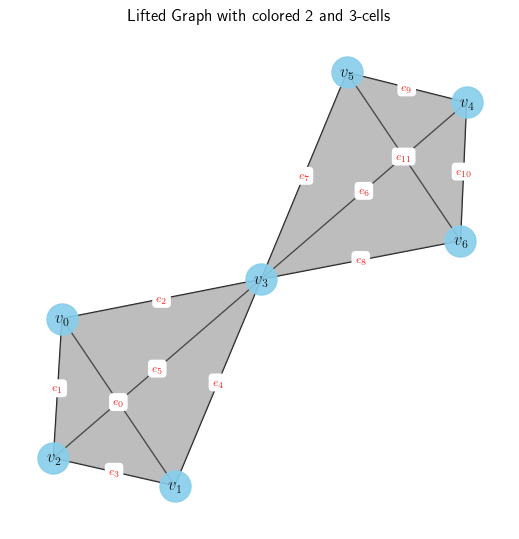

 - The complex has 7 0-cells.
 - The 0-cells have features dimension 2
 - The complex has 12 1-cells.
 - The 1-cells have features dimension 2
 - The complex has 8 2-cells.
 - The 2-cells have features dimension 2
 - The complex has 2 3-cells.
 - The 3-cells have features dimension 2



In [8]:
transform_config["lifting"]["feature_percent"] = 1.0
transform_config["lifting"]["max_edge_length"] = 1.0
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

In [9]:
lifted_dataset.get(0).incidence_3

tensor(indices=tensor([[0, 1, 2, 3, 4, 5, 6, 7],
                       [0, 0, 0, 0, 1, 1, 1, 1]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1.]),
       size=(8, 2), nnz=8, layout=torch.sparse_coo)

Finally we test `feature_percent=0.2`, an intermediate value where the distances are mostly determined by the positions, with a small influence from the features. We see that the geometry is now different from both of the other two cases.


Dataset only contains 1 sample:


Processing...
Done!


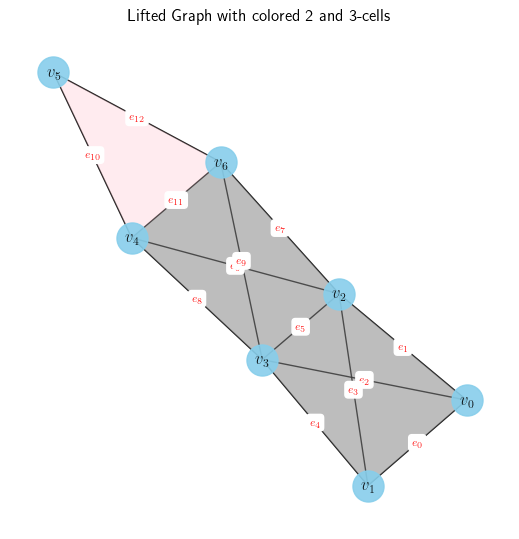

 - The complex has 7 0-cells.
 - The 0-cells have features dimension 2
 - The complex has 13 1-cells.
 - The 1-cells have features dimension 2
 - The complex has 9 2-cells.
 - The 2-cells have features dimension 2
 - The complex has 2 3-cells.
 - The 3-cells have features dimension 2



In [10]:
transform_config["lifting"]["feature_percent"] = 0.2
transform_config["lifting"]["max_edge_length"] = 10
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

When might feature-based Rips Complexes be useful? Suppose we have a point cloud dataset that actually consists of samples from multiple **independent objects**. For example, disjoint spheres. If two of the spheres are very close to one another, the standard Rips complex may generate a topology which incorrectly connects these two spheres. If a feature contribution is added, these spheres may have quite different feature vectors allowing the 'correct' geometry to be inferred.

Another use case is to generate more expressive message-passing toplogies. One might want to have two message-passing networks, one which operates over the usual Euclidean metric topology, while the other use the feature-based topology. This can allow for more complex interactions to be embedded in the topology of the lifted point cloud.

## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `up_laplacian_1` and the `down_laplacian_1` so the lifting should make sure to add them to the data.

In [11]:
from modules.models.simplicial.san import SANModel

model_type = "simplicial"
model_id = "san"
model_config = load_model_config(model_type, model_id)
model = SANModel(model_config, dataset_config)


Model configuration for simplicial SAN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'n_filters': 2,
 'order_harmonic': 5,
 'epsilon_harmonic': 0.1}


In [12]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 